                                CS5234 Combinatorial And Graph Algorithms
                                

Progress Report.

We have found two dataset, one the text data and the other is image data. We have already perfomred random projection on the text data, and tried Kmean clustering.
                                

** Some helpful links for learning about the basics of random projection and J-L lemma **


#### J-L Lemma
* This blog post http://www.johnmyleswhite.com/notebook/2014/03/24/a-note-on-the-johnson-lindenstrauss-lemma/ is a good start for learning about J-L lemma and random projection. DO READ IT.

#### Random Projection
* This paper http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.76.8124&rep=rep1&type=pdf gives a thorough introduction of random projection and its experimental performance.

#### Working with RP in sklearn
* Random projection: http://scikit-learn.org/stable/modules/random_projection.html
* J-L lemma: http://scikit-learn.org/stable/auto_examples/plot_johnson_lindenstrauss_bound.html


In [1]:
import numpy as np
from sklearn import random_projection
from sklearn import neighbors, datasets, metrics, cross_validation
from sklearn.decomposition import PCA
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
import timeit

C:\Users\chensz\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Using sklearn for Random Projection
The following few blocks demonstrate how we can perform random projection using sklearn. 

In [2]:
# the min dimension that guarantees the specific epsilon, determined by J-L Lemma
k_min = johnson_lindenstrauss_min_dim(n_samples=1e3, eps=0.2)
k_min

1594

In [3]:
# Examplar data before random projection
X = np.random.rand(1000, 10000) # the first dim is number of samples, second is original number of features

In [4]:
RP = random_projection.GaussianRandomProjection(n_components=k_min, eps=0.2)

In [5]:
# Result after random projection
X_new = RP.fit_transform(X)
X_new.shape

(1000, 1594)

In [6]:
SRP = random_projection.SparseRandomProjection(n_components=k_min, eps=0.2)

In [7]:
# Result after sparse random projection
X_new = SRP.fit_transform(X)
X_new.shape

(1000, 1594)

# Using RP on Text Data

In [8]:
from sklearn.datasets import fetch_20newsgroups_vectorized, fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from time import time
from sklearn.random_projection import SparseRandomProjection

In [9]:
data = fetch_20newsgroups_vectorized().data[:500]

In [10]:
n_samples, n_features = data.shape
print("Embedding %d samples with dim %d using various random projections"
      % (n_samples, n_features))

n_components_range = np.array([1000, 2000]) # can try with 300, 1000, 10000
dists = euclidean_distances(data, squared=True).ravel()

# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]

Embedding 500 samples with dim 130107 using various random projections


In [11]:
k_min = johnson_lindenstrauss_min_dim(n_samples=n_features, eps=0.2)
print("Require %d dimensions after projection according to J-L lemma"
      % (k_min))

Require 2717 dimensions after projection according to J-L lemma


Projected 500 samples from 130107 to 1000 in 0.524s
Random matrix with size: 4.343MB
Mean distances rate: 0.98 (0.10)
Projected 500 samples from 130107 to 2000 in 1.042s
Random matrix with size: 8.662MB
Mean distances rate: 1.02 (0.07)


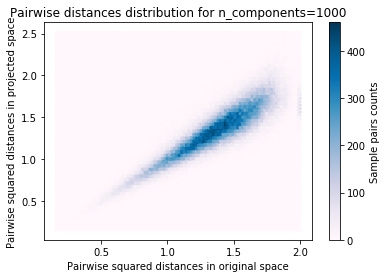

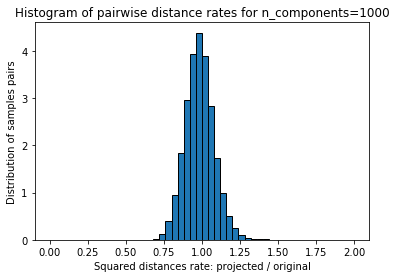

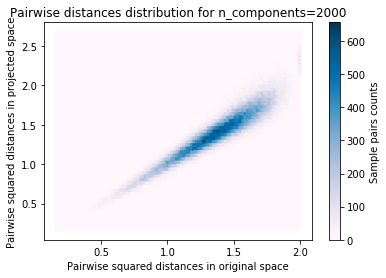

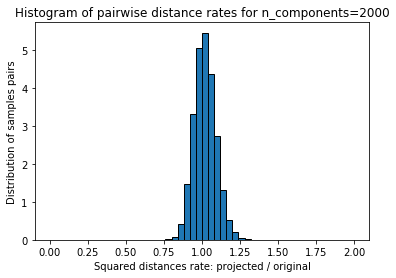

In [12]:
for n_components in n_components_range:
    t0 = time()
    rp = SparseRandomProjection(n_components=n_components)
    projected_data = rp.fit_transform(data)
    print("Projected %d samples from %d to %d in %0.3fs"
          % (n_samples, n_features, n_components, time() - t0))
    if hasattr(rp, 'components_'):
        n_bytes = rp.components_.data.nbytes
        n_bytes += rp.components_.indices.nbytes
        print("Random matrix with size: %0.3fMB" % (n_bytes / 1e6))

    projected_dists = euclidean_distances(
        projected_data, squared=True).ravel()[nonzero]

    plt.figure()
    plt.hexbin(dists, projected_dists, gridsize=100, cmap=plt.cm.PuBu)
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d" %
              n_components)
    cb = plt.colorbar()
    cb.set_label('Sample pairs counts')

    rates = projected_dists / dists
    print("Mean distances rate: %0.2f (%0.2f)"
          % (np.mean(rates), np.std(rates)))

    plt.figure()
    plt.hist(rates, bins=50, normed=True, range=(0., 2.), edgecolor='k')
    plt.xlabel("Squared distances rate: projected / original")
    plt.ylabel("Distribution of samples pairs")
    plt.title("Histogram of pairwise distance rates for n_components=%d" %
              n_components)

plt.show()

# Using RP on Image Data

In [13]:
# TODO: find some image dataset, better with label,
# so that it can be used both for clustering and kNN.
# Surveillance camera data can be a fit.

# Clustering on Text Data

In [56]:
# Prepare data.

from sklearn.feature_extraction.text import TfidfVectorizer

# Load some categories from the training set
categories = ['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset using a sparse vectorizer")
vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                                 min_df=2, stop_words='english',
                                 use_idf=True)
X = vectorizer.fit_transform(dataset.data)
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()


18846 documents
20 categories

Extracting features from the training dataset using a sparse vectorizer
done in 431.726813s
n_samples: 18846, n_features: 10000



In [57]:
# Cluster before PR
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=False)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=20, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 63.178s

Homogeneity: 0.339
Completeness: 0.418
V-measure: 0.375
Adjusted Rand-Index: 0.125
Silhouette Coefficient: 0.006



In [74]:
print(X.shape)

#from 10000 -> 2000. (dimension reduction)
n_components = 2000


# Apply RP

RP = random_projection.GaussianRandomProjection(n_components=n_components)
vectors_RP = RP.fit_transform(X)
print(vectors_RP.shape)

#Output:
#Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
#    n_clusters=20, n_init=1, n_jobs=1, precompute_distances='auto',
#    random_state=None, tol=0.0001, verbose=False)
#done in 20.899s

#Homogeneity: 0.337
#Completeness: 0.411
#V-measure: 0.370
#Adjusted Rand-Index: 0.144
#Silhouette Coefficient: 0.009


# Apply SRP (take very long time to cluster....)
n_components = 2000
SRP = random_projection.SparseRandomProjection(n_components=n_components)
# Result after random projection
vectors_SRP = SRP.fit_transform(X)
print(vectors_SRP.shape)


# Apply LSA
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
vectors_LSA = lsa.fit_transform(X)
print(vectors_LSA.shape)


#Output:
#Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
#    n_clusters=20, n_init=1, n_jobs=1, precompute_distances='auto',
#    random_state=None, tol=0.0001, verbose=False)
#done in 10.961s

#Homogeneity: 0.399
#Completeness: 0.479
#V-measure: 0.436
#Adjusted Rand-Index: 0.184
#Silhouette Coefficient: 0.009

(18846, 10000)
(18846, 2000)
(18846, 2000)
(18846, 2000)


In [75]:
# After RP.
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=False)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(vectors_LSA)
print("done in %0.3fs" % (time() - t0))
print()
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=20, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 10.961s

Homogeneity: 0.399
Completeness: 0.479
V-measure: 0.436
Adjusted Rand-Index: 0.184
Silhouette Coefficient: 0.009



# kNN on Text Data

## Data Preprocessing

In [9]:
# TODO: perform kNN on our text dataset
# compare **performance** and **time complexity** before
# and after random projection.
newsgroups_train = fetch_20newsgroups(subset='train')

In [16]:
# All the categories in the dataset
# we do not need to use all of them
# for the sake of running time
list(newsgroups_train.target_names)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [16]:
newsgroups_train.target

array([7, 4, 4, ..., 3, 1, 8])

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
categories = ['alt.atheism', 'talk.religion.misc',
              'comp.graphics', 'sci.med', 'talk.politics.mideast']
newsgroups_train_and_test = fetch_20newsgroups(subset='train',
                                categories=categories)
# newsgroups_train_and_test = fetch_20newsgroups(subset='train')
print(len(newsgroups_train_and_test.filenames))
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train_and_test.data) 

# Notice that the vectors returned above is in scipy sparse matrix format.
# we would like to convert it to normal numpy format
vectors = vectors.toarray()
vectors.shape

2599


(2599L, 41853L)

## Performance Evaluation Function

In [75]:
def test_classifier(X, y, clf, test_size=0.4, y_names=None, confusion=False):
    # train-test split
    print 'test size is: %2.0f%%' % (test_size * 100)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size)

    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)

    if not confusion:
        print('Classification report:')
        print metrics.classification_report(y_test, y_predicted, target_names=y_names)
    else:
        print('Confusion Matrix:')
        print metrics.confusion_matrix(y_test, y_predicted)

** Since `test_classifier` only split the dataset and run classification once, we are supposed to run it several times and take the mean as the evaluation result of the performance. For the ease of this project, we just run it once, though we must claim in our report that our evaluation result is taken as the mean of several experiments, say 20.**

## Set up kNN Classifier

In [76]:
n_neighbors = 15
weights = 'uniform'
# weights = 'distance'
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

## kNN on Original Data

In [78]:
start_time = timeit.default_timer()
test_classifier(vectors, newsgroups_train_and_test.target, clf, y_names=newsgroups_train_and_test.target_names, confusion=False)
elapsed_original = timeit.default_timer() - start_time

test size is: 40%
Classification report:
                       precision    recall  f1-score   support

          alt.atheism       0.61      0.95      0.74       194
        comp.graphics       0.98      0.71      0.82       225
              sci.med       0.97      0.68      0.80       241
talk.politics.mideast       0.71      0.99      0.83       222
   talk.religion.misc       0.93      0.56      0.70       158

          avg / total       0.84      0.79      0.79      1040



In [79]:
print(elapsed_original)

122.476103025


## kNN on Data after RP

In [84]:
start_time = timeit.default_timer()
# Apply RP
n_components = 2000
RP = random_projection.GaussianRandomProjection(n_components=n_components)
# Result after random projection
vectors_RP = RP.fit_transform(vectors)
vectors_RP.shape
elapsed_transform_RP = timeit.default_timer() - start_time

In [85]:
print(elapsed_transform_RP)

8.22928289845


In [86]:
start_time = timeit.default_timer()
test_classifier(vectors_RP, newsgroups_train_and_test.target, clf, y_names=newsgroups_train_and_test.target_names, confusion=False)
elapsed_RP = timeit.default_timer() - start_time

test size is: 40%
Classification report:
                       precision    recall  f1-score   support

          alt.atheism       0.66      0.89      0.75       193
        comp.graphics       0.97      0.70      0.82       218
              sci.med       0.89      0.79      0.83       225
talk.politics.mideast       0.77      0.96      0.85       247
   talk.religion.misc       0.80      0.59      0.68       157

          avg / total       0.82      0.80      0.80      1040



In [87]:
print(elapsed_RP)

6.14132182734


## kNN on Data after SRP

In [92]:
start_time = timeit.default_timer()
# Apply SRP
n_components = 2000
SRP = random_projection.SparseRandomProjection(n_components=n_components)
# Result after random projection
vectors_SRP = SRP.fit_transform(vectors)
vectors_SRP.shape
elapsed_transform_SRP = timeit.default_timer() - start_time

In [93]:
print(elapsed_transform_SRP)

3.13289695083


In [94]:
start_time = timeit.default_timer()
test_classifier(vectors_SRP, newsgroups_train_and_test.target, clf, y_names=newsgroups_train_and_test.target_names, confusion=False)
elapsed_SRP = timeit.default_timer() - start_time

test size is: 40%
Classification report:
                       precision    recall  f1-score   support

          alt.atheism       0.79      0.88      0.83       180
        comp.graphics       0.72      0.90      0.80       227
              sci.med       0.93      0.61      0.74       258
talk.politics.mideast       0.79      0.92      0.85       230
   talk.religion.misc       0.83      0.66      0.73       145

          avg / total       0.81      0.80      0.79      1040



In [95]:
print(elapsed_SRP)

6.19852198839


## kNN on Data after PCA

In [100]:
start_time = timeit.default_timer()
# Apply PCA
n_components = 2000
pca = PCA(n_components=n_components)
# Result after random projection
vectors_PCA = pca.fit(vectors).transform(vectors)
vectors_PCA.shape
elapsed_transform_PCA = timeit.default_timer() - start_time

In [101]:
print(elapsed_transform_PCA)

110.715284305


In [102]:
start_time = timeit.default_timer()
test_classifier(vectors_PCA, newsgroups_train_and_test.target, clf, y_names=newsgroups_train_and_test.target_names, confusion=False)
elapsed_PCA = timeit.default_timer() - start_time

test size is: 40%
Classification report:
                       precision    recall  f1-score   support

          alt.atheism       0.69      0.87      0.77       207
        comp.graphics       0.98      0.67      0.79       234
              sci.med       0.99      0.63      0.77       242
talk.politics.mideast       0.56      0.99      0.72       216
   talk.religion.misc       0.85      0.50      0.63       141

          avg / total       0.82      0.74      0.75      1040



In [103]:
print(elapsed_PCA)

6.24135668185


# Clustering and kNN on Image Data

In [55]:
# TODO: perform clustering and kNN on our image dataset
# compare **performance** and **time complexity** before
# and after random projection.

from sklearn.datasets import load_sample_images
dataset = load_sample_images()     
len(dataset.images)            

2